In [1]:
import numpy as np
import pandas as pd
from os import path as osp
import os
from matplotlib import pyplot as plt
import lightgbm as lgb

from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, fbeta_score, mean_absolute_percentage_error
import utils

import pickle
def save_obj(obj, name):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open(name + '.pickle', 'rb') as f:
        return pickle.load(f)

In [2]:
import warnings

# 禁用FutureWarning警告
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
DATA_PATH = '/data'
MODEL_PAHT = '/work/model'
SEED = 2222
if not os.path.exists(MODEL_PAHT):
    os.mkdir(MODEL_PAHT)
    
data_type='train'

In [4]:
def q1(x):
    return x.quantile(0.1)
def q2(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.7)
def q4(x):
    return x.quantile(0.9)
def mode_max(x):
    return x.mode().max()
def mode_min(x):
    return x.mode().min()
def mode_mean(x):
    return x.mode().mean()
def mode_std(x):
    return x.mode().std()
def mode_len(x):
    return x.mode().shape[0]
def mode_times(x):
    return x.value_counts().iloc[0]

In [5]:
def get_data(data_type='train'):
    train_base = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_base.csv'))
    train_base = train_base.sort_values(['cust_wid']).reset_index(drop=True)
    train_view = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_view.csv'), encoding='gbk')
    train_trx = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_trx.csv'))

    # deal base gdr_cd
    train_base['gdr_cd'] = train_base['gdr_cd'].map({'M':1, 'F':2})
    train_base['gdr_cd'] = train_base['gdr_cd'].fillna(0)

    # deal base cty_cd
    train_base['cty_cd'] = train_base['cty_cd'].str.slice(stop=2)
    train_base.cty_cd = train_base.cty_cd.fillna('NAN')
    cty_map = ['C', '44', '11', 'A', '31', '32', '37', '21', '42', '61', 'B', '33', '50', '12', '35', '36', '51', '43', '62', '53', '34', '23', '65', '41', 'NAN']
    cty_map = dict(zip(cty_map, range(1,len(cty_map)+1)))
    train_base['cty_cd'] = train_base['cty_cd'].map(cty_map).fillna(0)

    # idx = train_view.acs_tm.str.contains('下午')
    train_view.acs_tm = train_view.acs_tm.str.rstrip(':').str.replace('上午|下午', '', regex=True).str.replace('1492', '2022')
    train_view.acs_tm = pd.to_datetime(train_view.acs_tm)
    train_view['day'] = train_view.acs_tm.dt.day

    train_trx.trx_tm = train_trx.trx_tm.str.replace('1492', '2022')
    train_trx.trx_tm = pd.to_datetime(train_trx.trx_tm)
    train_trx['day'] = train_trx.trx_tm.dt.day

    train_view['day_diff'] = train_view['day'].max() - train_view['day']
    train_trx['day_diff'] = train_trx['day'].max() - train_trx['day']

    if data_type=='train':
        train_view['day'] -= 4
        train_trx['day'] -= 4
    elif data_type=='testa':
        train_view['day'] -= 3
        train_trx['day'] -= 3
    elif data_type=='testb':
        train_view['day'] -= 4
        train_trx['day'] -= 4

    print(train_trx['day'].max(), train_trx['day'].min())

    train_view['ntimes'] = train_view['day']//14
    train_trx['ntimes'] = train_trx['day']//14
    train_view['day'] %= 14
    train_trx['day'] %= 14

#     train_idx = pd.Index(train_base['cust_wid'], name='cust_wid')
#     tmp_idx = train_view['acs_tm'].isna()
#     train_view_nan = pd.DataFrame({'cust_wid': train_view[tmp_idx]['cust_wid'].unique(), 'view_nan': 1}).set_index('cust_wid').reindex(train_idx).fillna(0).reset_index(drop=True)

#     tmp_idx = train_trx['trx_tm'].isna()
#     train_trx_nan = pd.DataFrame({'cust_wid': train_trx[tmp_idx]['cust_wid'].unique(), 'trx_nan': 1}).set_index('cust_wid').reindex(train_idx).fillna(0).reset_index(drop=True)

#     train_base = pd.concat([train_base, train_view_nan, train_trx_nan], axis=1)



    train_view = train_view.query('day>=0').reset_index(drop=True)
    train_trx = train_trx.query('day>=0').reset_index(drop=True)


    train_view['day'] = train_view['day'].astype('int')
    train_trx['day'] = train_trx['day'].astype('int')

    train_view = train_view.sort_values(['cust_wid','acs_tm']).reset_index(drop=True)
    train_trx = train_trx.sort_values(['cust_wid','trx_tm']).reset_index(drop=True)

    page_id_enc = load_obj(osp.join(MODEL_PAHT, 'page_id_enc'))
    trx_id_enc = load_obj(osp.join(MODEL_PAHT, 'trx_id_enc'))

    train_view['page_enc'] = train_view['page_id'].map(page_id_enc)
    train_view['page_enc'] = train_view['page_enc'].fillna(page_id_enc['NAN'])
    train_trx['trx_enc'] = train_trx['trx_cd'].map(trx_id_enc)

    train_view['acs_tm_diff'] = train_view.groupby('cust_wid')['acs_tm'].diff().dt.total_seconds()
    train_trx['trx_tm_diff'] = train_trx.groupby('cust_wid')['trx_tm'].diff().dt.total_seconds()
    train_view['daytime'] = train_view['acs_tm'].dt.time.apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
    train_trx['daytime'] = train_trx['trx_tm'].dt.time.apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
    train_trx['flag'] = (train_trx['trx_amt'] >0).astype('int')

    train_idx = pd.Index(train_base['cust_wid'], name='cust_wid')

    view_agg_func = {
        'day':['mean', 'min', 'max', 'std', np.ptp, 'nunique'],
        'page_id':['count', 'nunique'], 
        'acs_tm_diff':['mean', 'min', 'max', 'std', 'median', 'sum'], 
        'daytime':['mean', 'min', 'max', 'std', np.ptp],
        'page_enc': [
            'mean', 'min', 'max', 'std', 'median', 'sum', 
            np.ptp, "sem", "mad", "skew", pd.Series.kurtosis, 
            q1, q2, q3, q4, 'last',
            # mode_max, mode_min, mode_mean, mode_std, mode_len, mode_times
        ],
        'day_diff': ['min'],
    }
    train_view_c = train_view.groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    train_view_c.columns = [f'vie_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_c.columns]
    train_base = pd.concat([train_base, train_view_c], axis=1)

    #     train_view_cn1 = train_view.query('ntimes==1').groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_view_cn1.columns = [f'vie_d_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_cn1.columns]

    #     train_view_cn0 = train_view.query('ntimes==0').groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_view_cn0.columns = [f'vie_d_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_cn0.columns]

    #     train_view_c = train_view_cn1-train_view_cn0
    #     train_base = pd.concat([train_base, train_view_c], axis=1)

    trx_agg_func = {
        'day':['mean', 'min', 'max', 'std', np.ptp, 'nunique'],
        'trx_cd':['count', 'nunique'], 
        'trx_tm_diff':['mean', 'min', 'max', 'std', 'median', 'sum'], 
        'daytime':['mean', 'min', 'max', 'std', np.ptp], 
        'trx_amt':['mean', 'min', 'max', 'std', 'median', 'sum', np.ptp, 'last'],
        'trx_enc': ['mean', 'min', 'max', 'std', 'median', 'sum', np.ptp, 'last'],
        'day_diff': ['min'],
    }
    train_trx_c = train_trx.groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    train_trx_c.columns = [f'trx_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    train_base = pd.concat([train_base, train_trx_c], axis=1)

    #     train_trx_c = train_trx.query('flag==1').groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_trx_c.columns = [f'trx_1_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    #     train_base = pd.concat([train_base, train_trx_c], axis=1)

    #     train_trx_c = train_trx.query('flag==0').groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_trx_c.columns = [f'trx_0_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    #     train_base = pd.concat([train_base, train_trx_c], axis=1)

    train_view['group'] = (train_view['acs_tm_diff']>5*60).cumsum()
    train_view['group'] -= train_view['cust_wid'].map(train_view.groupby('cust_wid').agg({'group':'min'}).to_dict()['group'])
    train_reg_base = pd.DataFrame()

    train_view_group = train_view.groupby(['cust_wid', 'group']).agg({'page_enc': ['mean', 'min', 'max', 'std'], 'page_id':['count', 'nunique'], 'daytime':['mean',]}).reset_index()
    train_view_group.columns = [f'{item[0]}_{item[1]}' if item[0] not in ['cust_wid', 'group'] else item[0] for item in train_view_group.columns]
    train_view_group = train_view_group.groupby(['cust_wid']).agg({
        'group': ['max'],
        'page_enc_mean': ['mean', 'min', 'max', 'std'],
        'page_enc_min': ['mean', 'min', 'max', 'std'],
        'page_enc_max': ['mean', 'min', 'max', 'std'],
        'page_enc_std': ['mean', 'min', 'max', 'std'],
        'page_id_count': ['mean', 'min', 'max', 'std'],
        'page_id_nunique': ['mean', 'min', 'max', 'std'],
        'daytime_mean': ['mean', 'min', 'max', 'std'],
    }).reindex(train_idx).reset_index(drop=True)
    train_view_group.columns = [f'vie_gop_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_group.columns]
    train_reg_base = pd.concat([train_reg_base,train_view_group], axis=1)
    
    
    train_idx = pd.MultiIndex.from_product([train_base['cust_wid'], range(14)], names=['cust_wid', 'day'])
    train_view_cust = train_view.groupby(['cust_wid', 'day'])['page_id'].agg(['count', 'nunique']).reset_index()
    train_trx_cust = train_trx.groupby(['cust_wid', 'day'])[['trx_cd', 'trx_amt']].agg({'trx_cd':['count', 'nunique'], 'trx_amt':['min', 'max', 'mean', 'std']}).reset_index()
    train_trx_cust.columns = [f'{item[0]}_{item[1]}' if item[0] in ['trx_cd', 'trx_amt'] else item[0] for item in train_trx_cust.columns]

    train_view_cust = train_view_cust.set_index(['cust_wid','day']).reindex(train_idx).reset_index().sort_values(['cust_wid','day']).reset_index(drop=True)
    train_trx_cust = train_trx_cust.set_index(['cust_wid','day']).reindex(train_idx).reset_index().sort_values(['cust_wid','day']).reset_index(drop=True)

    train_view_cust = train_view_cust[[item for item in train_view_cust.columns if item not in ['cust_wid','day']]]
    train_view_cust_cols = train_view_cust.columns
    train_view_cust = train_view_cust.values.reshape(train_base['cust_wid'].shape[0], 14*len(train_view_cust_cols))
    train_view_cust = pd.DataFrame(train_view_cust, columns=[f"view_cust_{item}_{day}" for day in range(14) for item in train_view_cust_cols])

    train_trx_cust = train_trx_cust[[item for item in train_trx_cust.columns if item not in ['cust_wid','day']]]
    train_trx_cust_cols = train_trx_cust.columns
    train_trx_cust = train_trx_cust.values.reshape(train_base['cust_wid'].shape[0], 14*len(train_trx_cust_cols))
    train_trx_cust = pd.DataFrame(train_trx_cust, columns=[f"trx_cust_{item}_{day}" for day in range(14) for item in train_trx_cust_cols])
    train_reg_base = pd.concat([train_reg_base, train_view_cust, train_trx_cust], axis=1)

    return train_base, train_reg_base

In [6]:
# train_view_c = train_view.groupby(['cust_wid', 'day']).agg(view_agg_func)

In [7]:
# 众数

In [8]:
train_base, train_reg_base = get_data(data_type='train')
# testA_base, testA_reg_base = get_data(data_type='testa')
testB_base, testB_reg_base = get_data(data_type='testb')

27.0 -3.0
27.0 -3.0


In [9]:
train_base['label'] = 0
testB_base['label'] = 1


In [10]:
data = pd.concat([train_base, testB_base],axis=0)

In [11]:
FEATS = [item for item in train_base.columns if item not in ['cust_wid', 'label']+[
    'trx_trx_tm_diff_sum', 'trx_daytime_min', 'trx_trx_tm_diff_max', 'trx_trx_tm_diff_std','trx_day_diff_min', 
    'vie_day_std', 'vie_day_mean', 'vie_day_diff_min', 'trx_daytime_ptp',
    'vie_acs_tm_diff_sum', 'trx_trx_tm_diff_mean', 'trx_day_std'
]]
TARGET_COL = 'label'
print(len(FEATS))


63


In [12]:
print(FEATS)

['age', 'gdr_cd', 'cty_cd', 'vie_day_min', 'vie_day_max', 'vie_day_ptp', 'vie_day_nunique', 'vie_page_id_count', 'vie_page_id_nunique', 'vie_acs_tm_diff_mean', 'vie_acs_tm_diff_min', 'vie_acs_tm_diff_max', 'vie_acs_tm_diff_std', 'vie_acs_tm_diff_median', 'vie_daytime_mean', 'vie_daytime_min', 'vie_daytime_max', 'vie_daytime_std', 'vie_daytime_ptp', 'vie_page_enc_mean', 'vie_page_enc_min', 'vie_page_enc_max', 'vie_page_enc_std', 'vie_page_enc_median', 'vie_page_enc_sum', 'vie_page_enc_ptp', 'vie_page_enc_sem', 'vie_page_enc_mad', 'vie_page_enc_skew', 'vie_page_enc_kurt', 'vie_page_enc_q1', 'vie_page_enc_q2', 'vie_page_enc_q3', 'vie_page_enc_q4', 'vie_page_enc_last', 'trx_day_mean', 'trx_day_min', 'trx_day_max', 'trx_day_ptp', 'trx_day_nunique', 'trx_trx_cd_count', 'trx_trx_cd_nunique', 'trx_trx_tm_diff_min', 'trx_trx_tm_diff_median', 'trx_daytime_mean', 'trx_daytime_max', 'trx_daytime_std', 'trx_trx_amt_mean', 'trx_trx_amt_min', 'trx_trx_amt_max', 'trx_trx_amt_std', 'trx_trx_amt_median'

In [13]:
def corr_feats_func(feat_data, target_data):
    from scipy.stats import kendalltau, spearmanr, pearsonr
    idx = ~(np.isnan(feat_data) | np.isnan(target_data))
    tau, p_value = kendalltau(feat_data.loc[idx], target_data.loc[idx])
    return np.abs(tau)
def all_corr_data(train_x, train_y):
    from scipy.stats import kendalltau, spearmanr, pearsonr
    FEATURE_COLS = [i for i in train_x.columns if i not in ["sample_id", TARGET_COL, 'type']]
    corr_data = {}
    for item_feat in FEATURE_COLS:
        idx = ~(np.isnan(train_x[item_feat]) | np.isnan(train_y))
        tau, p_value = kendalltau(train_x.loc[idx, item_feat], train_y.loc[idx])
        corr_data[item_feat] = np.abs(tau)
    corr_data = pd.DataFrame(corr_data, index=["corr"]).T
    corr_data = corr_data.sort_values(by="corr", ascending=False)
    # corr_data.to_csv(f'EDA/corr_{BASE_LABEL}.csv', index=True)
    return corr_data

In [14]:
# print("去重前", len(FEATS))
# tmp = train_base[FEATS].T
# FEATURE_COLS = tmp.drop_duplicates().index.to_list()
# print("去重后", len(FEATURE_COLS))

# single_feats = []
# for item_feat in tqdm(FEATURE_COLS):
#     a = train_base[item_feat].value_counts()
#     if a.index.shape[0] <= 1 and item_feat not in ["id", "type"]:
#         continue
#     else:
#         single_feats.append(item_feat)
# FEATURE_COLS = single_feats
# print("去单后", len(FEATURE_COLS))

In [15]:
class cv_model():
    def __init__(self, task_name='lgb', nfold=5, seed=SEED, save_path=MODEL_PAHT):
        self.nfold = nfold
        self.seed = seed
        self.save_path = save_path
        self.models = []
        self.task_name = task_name
    
    def save_model(self):
        for i, model in enumerate(self.models):
            save_obj(model, os.path.join(self.save_path, f"{self.task_name}_fold_{i}"))
    
    def load_model(self):
        self.models = []
        for i in range(self.nfold):
            model = load_obj(os.path.join(self.save_path, f"{self.task_name}_fold_{i}"))
            self.models.append(model)
    
    def fit(self, params, train_x, train_y, cat_feats):
        kf = StratifiedKFold(n_splits=self.nfold, random_state=self.seed, shuffle=True)
        feat_imp = pd.DataFrame({'feat': train_x.columns})
        train_oof = np.zeros(len(train_x))
        for fold, (trn_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
            trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y.iloc[trn_idx], categorical_feature=cat_feats)
            val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y.iloc[val_idx], categorical_feature=cat_feats)
            model = lgb.train(
                params,
                trn_data,
                num_boost_round=30000,
                valid_sets=[trn_data, val_data],
                categorical_feature=cat_feats,
                callbacks=[
                    lgb.early_stopping(100),
                    lgb.log_evaluation(100)
                ]
            )
            train_oof[val_idx] = model.predict(train_x.iloc[val_idx], num_iteration=model.best_iteration)
            self.models.append(model)
            feat_imp[f'fold_{fold}'] = feat_imp['feat'].map(dict(zip(model.feature_name(), model.feature_importance())))
        return train_oof, feat_imp
    def predict(self, test_x):
        test_pred = np.zeros(len(test_x))
        for i, model in enumerate(self.models):
            test_pred+=model.predict(test_x, num_iteration=model.best_iteration)/len(self.models)
        return test_pred
                                                         
            
            


In [16]:
cla_params = {
    'objective': 'binary', # multiclass multiclassova
    'metric': 'auc', #  average_precision auc map
    'boosting_type': 'gbdt',
    'num_leaves': 16,
    'min_data_in_leaf': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_fraction_seed':SEED,
    'bagging_seed':SEED,
    'seed': SEED,
}

train_cla_x = data[FEATS]
train_cla_y = data[TARGET_COL]
# testB_cla_x = testB_base[FEATS]
# print(train_cla_x.shape, train_cla_y.shape, testB_cla_x.shape)

cla_model = cv_model(task_name='cla_lgb_dui', nfold=10)
train_cla_oof, feat_cla_imp = cla_model.fit(cla_params, train_cla_x, train_cla_y, cat_feats=['gdr_cd','cty_cd'])
cla_model.save_model()
cla_model.load_model()
# test_cla_pred = cla_model.predict(testB_cla_x)


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.83062	valid_1's auc: 0.829365
[200]	training's auc: 0.85658	valid_1's auc: 0.851829
[300]	training's auc: 0.870799	valid_1's auc: 0.863226
[400]	training's auc: 0.879574	valid_1's auc: 0.869135
[500]	training's auc: 0.886439	valid_1's auc: 0.873001
[600]	training's auc: 0.891719	valid_1's auc: 0.874967
[700]	training's auc: 0.896363	valid_1's auc: 0.876182
[800]	training's auc: 0.90078	valid_1's auc: 0.87729
[900]	training's auc: 0.904951	valid_1's auc: 0.878488
[1000]	training's auc: 0.90864	valid_1's auc: 0.879186
[1100]	training's auc: 0.912233	valid_1's auc: 0.879774
[1200]	training's auc: 0.915608	valid_1's auc: 0.880314
[1300]	training's auc: 0.918927	valid_1's auc: 0.880816
[1400]	training's auc: 0.921901	valid_1's auc: 0.880994
[1500]	training's auc: 0.92461	valid_1's auc: 0.881393
[1600]	training's auc: 0.927418	valid_1's auc: 0.881455
[1700]	training's auc: 0.930113	valid_1's auc: 0.881891
[

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.830219	valid_1's auc: 0.824768
[200]	training's auc: 0.856932	valid_1's auc: 0.849126
[300]	training's auc: 0.870748	valid_1's auc: 0.86081
[400]	training's auc: 0.88006	valid_1's auc: 0.866839
[500]	training's auc: 0.886648	valid_1's auc: 0.870109
[600]	training's auc: 0.89204	valid_1's auc: 0.87192
[700]	training's auc: 0.896921	valid_1's auc: 0.874057
[800]	training's auc: 0.901098	valid_1's auc: 0.87531
[900]	training's auc: 0.905106	valid_1's auc: 0.876051
[1000]	training's auc: 0.90896	valid_1's auc: 0.877021
[1100]	training's auc: 0.912654	valid_1's auc: 0.877596
[1200]	training's auc: 0.91605	valid_1's auc: 0.878143
[1300]	training's auc: 0.91923	valid_1's auc: 0.878703
[1400]	training's auc: 0.922195	valid_1's auc: 0.879048
[1500]	training's auc: 0.925084	valid_1's auc: 0.879481
[1600]	training's auc: 0.927806	valid_1's auc: 0.879783
[1700]	training's auc: 0.930331	valid_1's auc: 0.879837
[18

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.83201	valid_1's auc: 0.827339
[200]	training's auc: 0.858404	valid_1's auc: 0.850455
[300]	training's auc: 0.872115	valid_1's auc: 0.862035
[400]	training's auc: 0.880804	valid_1's auc: 0.867865
[500]	training's auc: 0.8872	valid_1's auc: 0.871276
[600]	training's auc: 0.892511	valid_1's auc: 0.873192
[700]	training's auc: 0.897165	valid_1's auc: 0.874475
[800]	training's auc: 0.901638	valid_1's auc: 0.875905
[900]	training's auc: 0.90542	valid_1's auc: 0.87666
[1000]	training's auc: 0.909117	valid_1's auc: 0.877217
[1100]	training's auc: 0.912795	valid_1's auc: 0.877605
[1200]	training's auc: 0.916047	valid_1's auc: 0.878452
[1300]	training's auc: 0.919173	valid_1's auc: 0.878749
[1400]	training's auc: 0.92213	valid_1's auc: 0.879094
[1500]	training's auc: 0.924882	valid_1's auc: 0.879662
[1600]	training's auc: 0.927747	valid_1's auc: 0.880101
[1700]	training's auc: 0.93043	valid_1's auc: 0.880632
[1

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.831209	valid_1's auc: 0.825914
[200]	training's auc: 0.857332	valid_1's auc: 0.850681
[300]	training's auc: 0.87137	valid_1's auc: 0.862389
[400]	training's auc: 0.880286	valid_1's auc: 0.868368
[500]	training's auc: 0.886642	valid_1's auc: 0.870999
[600]	training's auc: 0.892037	valid_1's auc: 0.872881
[700]	training's auc: 0.896947	valid_1's auc: 0.874476
[800]	training's auc: 0.901043	valid_1's auc: 0.875101
[900]	training's auc: 0.905116	valid_1's auc: 0.876213
[1000]	training's auc: 0.908886	valid_1's auc: 0.876993
[1100]	training's auc: 0.912357	valid_1's auc: 0.877496
[1200]	training's auc: 0.915762	valid_1's auc: 0.878174
[1300]	training's auc: 0.919036	valid_1's auc: 0.878468
[1400]	training's auc: 0.921894	valid_1's auc: 0.878927
[1500]	training's auc: 0.924934	valid_1's auc: 0.879263
[1600]	training's auc: 0.927904	valid_1's auc: 0.879655
[1700]	training's auc: 0.930448	valid_1's auc: 0.879

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.833419	valid_1's auc: 0.823584
[200]	training's auc: 0.857858	valid_1's auc: 0.846088
[300]	training's auc: 0.872209	valid_1's auc: 0.858377
[400]	training's auc: 0.880899	valid_1's auc: 0.864293
[500]	training's auc: 0.887365	valid_1's auc: 0.867236
[600]	training's auc: 0.892695	valid_1's auc: 0.869614
[700]	training's auc: 0.897342	valid_1's auc: 0.870888
[800]	training's auc: 0.901663	valid_1's auc: 0.871864
[900]	training's auc: 0.905611	valid_1's auc: 0.872581
[1000]	training's auc: 0.909302	valid_1's auc: 0.873347
[1100]	training's auc: 0.912797	valid_1's auc: 0.873625
[1200]	training's auc: 0.916104	valid_1's auc: 0.874171
[1300]	training's auc: 0.91927	valid_1's auc: 0.874555
[1400]	training's auc: 0.922306	valid_1's auc: 0.875033
[1500]	training's auc: 0.925144	valid_1's auc: 0.875471
[1600]	training's auc: 0.928057	valid_1's auc: 0.875837
[1700]	training's auc: 0.930558	valid_1's auc: 0.876

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.829986	valid_1's auc: 0.828168
[200]	training's auc: 0.856239	valid_1's auc: 0.85105
[300]	training's auc: 0.871041	valid_1's auc: 0.862705
[400]	training's auc: 0.87974	valid_1's auc: 0.867954
[500]	training's auc: 0.886347	valid_1's auc: 0.871375
[600]	training's auc: 0.891635	valid_1's auc: 0.873555
[700]	training's auc: 0.896447	valid_1's auc: 0.87545
[800]	training's auc: 0.900802	valid_1's auc: 0.876314
[900]	training's auc: 0.904887	valid_1's auc: 0.877538
[1000]	training's auc: 0.908537	valid_1's auc: 0.878557
[1100]	training's auc: 0.912095	valid_1's auc: 0.879112
[1200]	training's auc: 0.915347	valid_1's auc: 0.879082
[1300]	training's auc: 0.918531	valid_1's auc: 0.87964
[1400]	training's auc: 0.921449	valid_1's auc: 0.879928
[1500]	training's auc: 0.924487	valid_1's auc: 0.880347
[1600]	training's auc: 0.927367	valid_1's auc: 0.880859
[1700]	training's auc: 0.930029	valid_1's auc: 0.880864

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.831582	valid_1's auc: 0.824649
[200]	training's auc: 0.85717	valid_1's auc: 0.847177
[300]	training's auc: 0.871671	valid_1's auc: 0.859648
[400]	training's auc: 0.880449	valid_1's auc: 0.865754
[500]	training's auc: 0.886859	valid_1's auc: 0.86911
[600]	training's auc: 0.89219	valid_1's auc: 0.871229
[700]	training's auc: 0.896982	valid_1's auc: 0.872697
[800]	training's auc: 0.901364	valid_1's auc: 0.873793
[900]	training's auc: 0.90558	valid_1's auc: 0.874737
[1000]	training's auc: 0.909279	valid_1's auc: 0.875282
[1100]	training's auc: 0.912553	valid_1's auc: 0.876058
[1200]	training's auc: 0.915895	valid_1's auc: 0.87648
[1300]	training's auc: 0.919136	valid_1's auc: 0.877001
[1400]	training's auc: 0.922129	valid_1's auc: 0.87731
[1500]	training's auc: 0.925052	valid_1's auc: 0.87793
[1600]	training's auc: 0.927955	valid_1's auc: 0.878297
[1700]	training's auc: 0.93055	valid_1's auc: 0.87847
[180

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.830763	valid_1's auc: 0.825734
[200]	training's auc: 0.857384	valid_1's auc: 0.850091
[300]	training's auc: 0.87124	valid_1's auc: 0.86154
[400]	training's auc: 0.880457	valid_1's auc: 0.86808
[500]	training's auc: 0.887235	valid_1's auc: 0.871842
[600]	training's auc: 0.892401	valid_1's auc: 0.873579
[700]	training's auc: 0.897092	valid_1's auc: 0.874966
[800]	training's auc: 0.901171	valid_1's auc: 0.876153
[900]	training's auc: 0.904991	valid_1's auc: 0.876497
[1000]	training's auc: 0.908739	valid_1's auc: 0.877457
[1100]	training's auc: 0.912431	valid_1's auc: 0.878107
[1200]	training's auc: 0.915912	valid_1's auc: 0.878632
[1300]	training's auc: 0.919145	valid_1's auc: 0.879359
[1400]	training's auc: 0.92202	valid_1's auc: 0.87962
[1500]	training's auc: 0.924867	valid_1's auc: 0.87972
[1600]	training's auc: 0.927631	valid_1's auc: 0.880113
[1700]	training's auc: 0.930256	valid_1's auc: 0.880457
[

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.830247	valid_1's auc: 0.829153
[200]	training's auc: 0.857006	valid_1's auc: 0.852957
[300]	training's auc: 0.870789	valid_1's auc: 0.864459
[400]	training's auc: 0.879227	valid_1's auc: 0.870044
[500]	training's auc: 0.886142	valid_1's auc: 0.874592
[600]	training's auc: 0.891332	valid_1's auc: 0.876271
[700]	training's auc: 0.896114	valid_1's auc: 0.87767
[800]	training's auc: 0.900596	valid_1's auc: 0.878976
[900]	training's auc: 0.904443	valid_1's auc: 0.879656
[1000]	training's auc: 0.908297	valid_1's auc: 0.880672
[1100]	training's auc: 0.911788	valid_1's auc: 0.881203
[1200]	training's auc: 0.915103	valid_1's auc: 0.881837
[1300]	training's auc: 0.918323	valid_1's auc: 0.882376
[1400]	training's auc: 0.921342	valid_1's auc: 0.882926
[1500]	training's auc: 0.924277	valid_1's auc: 0.88303
[1600]	training's auc: 0.927064	valid_1's auc: 0.883462
[1700]	training's auc: 0.929824	valid_1's auc: 0.8838

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.83197	valid_1's auc: 0.825068
[200]	training's auc: 0.856878	valid_1's auc: 0.848201
[300]	training's auc: 0.871228	valid_1's auc: 0.860961
[400]	training's auc: 0.88024	valid_1's auc: 0.866922
[500]	training's auc: 0.886641	valid_1's auc: 0.869966
[600]	training's auc: 0.891832	valid_1's auc: 0.872215
[700]	training's auc: 0.896687	valid_1's auc: 0.874354
[800]	training's auc: 0.900944	valid_1's auc: 0.875146
[900]	training's auc: 0.905012	valid_1's auc: 0.875989
[1000]	training's auc: 0.908693	valid_1's auc: 0.876674
[1100]	training's auc: 0.912389	valid_1's auc: 0.87757
[1200]	training's auc: 0.915469	valid_1's auc: 0.877966
[1300]	training's auc: 0.918761	valid_1's auc: 0.878658
[1400]	training's auc: 0.92184	valid_1's auc: 0.87901
[1500]	training's auc: 0.924856	valid_1's auc: 0.879712
[1600]	training's auc: 0.927586	valid_1's auc: 0.880191
[1700]	training's auc: 0.930236	valid_1's auc: 0.880522


In [17]:
thr_optimal, best_fscore = utils.get_optimal_Fscore(train_cla_y, train_cla_oof)
thr_optimal, best_fscore, (train_cla_oof>thr_optimal).sum() / train_cla_oof.shape[0]

以精度为0.1在[0.1,0.8]范围内搜索F1最佳阈值>>最佳阈值:=0.2->F1=0.80238105
以精度为0.02在[0.1,0.28]范围内搜索F1最佳阈值>>最佳阈值:=0.18000000000000002->F1=0.80401817
以精度为0.004在[0.13,0.2260000000000001]范围内搜索F1最佳阈值>>最佳阈值:=0.17800000000000005->F1=0.80408693


(0.17800000000000005, 0.80408693, 0.5764933333333333)

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_cla_y, train_cla_oof)

0.8818454574

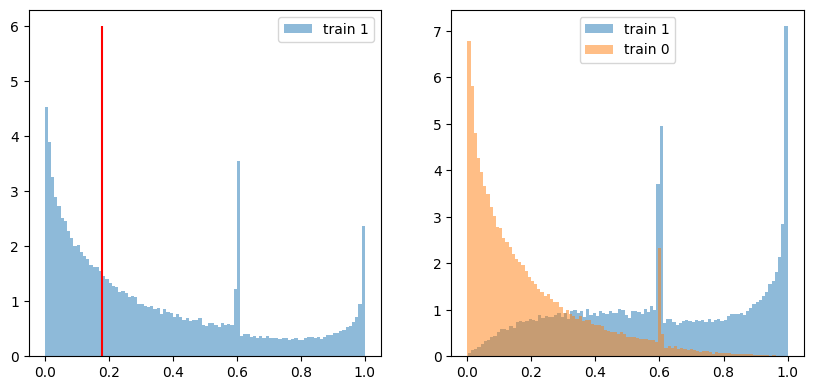

In [19]:
plt.figure(figsize=(10,4.5))
plt.subplot(121)
plt.hist(train_cla_oof, bins=100, alpha=0.5, label='train 1', density=True)
# plt.hist(test_cla_pred, bins=100, alpha=0.5, label='testB', density=True)
plt.vlines(thr_optimal, 0, 6, color='r')
plt.legend()

plt.subplot(122)
idx = train_cla_y==1
plt.hist(train_cla_oof[idx], bins=100, alpha=0.5, label='train 1', density=True)
plt.hist(train_cla_oof[~idx], bins=100, alpha=0.5, label='train 0', density=True)
plt.legend()

In [20]:
feat_cla_imp['mean'] = feat_cla_imp[[f"fold_{fold}" for fold in range(cla_model.nfold)]].mean(axis=1)
feat_cla_imp = feat_cla_imp.sort_values(by="mean", ascending=False)
feat_cla_imp.to_csv('model/feats_cla_dui_imp.csv', index=False)

In [21]:
corr_data = all_corr_data(train_cla_x,train_cla_y)
corr_data.to_csv('model/corr_dui_cla.csv')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [34]:
oof = pd.DataFrame({'cust_wid':data['cust_wid'], 'prob':train_cla_oof})
oof = oof[:100000]

In [37]:
save_obj(oof,'model/prob')

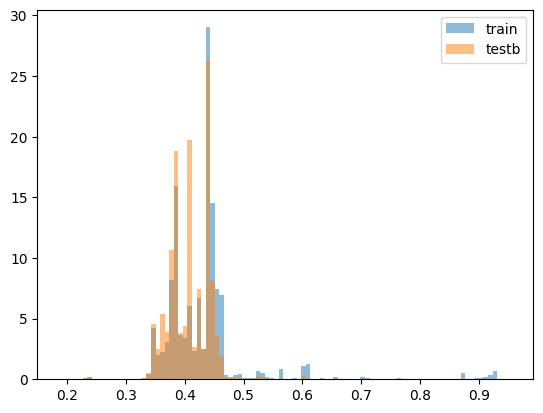

In [50]:
plot_feats = 'vie_page_enc_median'
bins = np.linspace(data[plot_feats].min(), data[plot_feats].max(), 100)
plt.hist(train_base[plot_feats], bins=bins, density=True, alpha=0.5, label='train')
plt.hist(testB_base[plot_feats], bins=bins, density=True, alpha=0.5, label='testb')
plt.legend()

In [ ]:
import scipy.stats
def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M, base=2)+0.5*scipy.stats.entropy(q, M, base=2)
def get_JS_score(train_data, testA_data):
    bins = np.linspace(min(train_data.min(), testA_data.min()), max(train_data.max(), testA_data.max()), 100)
    a = plt.hist(train_data, label='train', density=True, alpha=0.5, bins=bins)[0]
    b = plt.hist(testA_data, label='test', density=True, alpha=0.5, bins=bins)[0]
    js = JS_divergence(a, b)
    return js

results = {}
for item_feat in tqdm(FEATS):
    results[item_feat] = get_JS_score(train_base[item_feat], testB_base[item_feat])
results = pd.DataFrame(results, index=['JS']).T.sort_values('JS', ascending=False)
results.to_csv('JS.csv')